# Fine Tune

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

import torch
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset

import tqdm as tqdm

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Dataset

In [2]:
mbti_df = pd.read_csv('../processed/all_data_3.csv')

In [3]:
mbti_df

,Unnamed: 0,type,tweet
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl..."
1,1,ISFJ,Tinder has your health in mind.
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker
3,3,ISFJ,Outstanding faculty from and more at Winter Co...
4,4,ISFJ,"Using pray and wait on God, can be a means of ..."
...,...,...,...
106322,106322,ESTP,This is so legit holy shit lol I work in rando...
106323,106323,ESTP,Same here When Im in a group Im fairly quiet u...
106324,106324,ESTJ,Im more worried about the idea that we are sla...
106325,106325,ESTP,Believing you dont have ethics is still an eth...


### Add column `introvert_extrovert`

In [4]:
mbti_df['feeling_thinking'] = mbti_df['type'].apply(lambda x: 'Feeling' if x[2] == 'F' else 'Thinking')

In [5]:
mbti_df.sample(10)

,Unnamed: 0,type,tweet,feeling_thinking
92904,92904,ISFJ,you know youre a sensor when the reason you wa...,Feeling
1902,1902,ENFJ,haha well i think it was unlikely hormones or ...,Feeling
54610,54610,INTJ,so why cant she bring her friend along then yo...,Thinking
103782,103782,ESTJ,I sometimes enjoy being a snarky bastard But I...,Thinking
74035,74035,ISTJ,when i was together with my exgirlfriend she p...,Thinking
53227,53227,INTJ,gt Sociability is required for success This ca...,Thinking
89379,89379,ESFP,i think im just going to go by cognitive funct...,Feeling
66702,66702,ISFP,i like stuff i like a nice distance every now ...,Feeling
72548,72548,ISFP,Arrgh when people dont close their mouth when ...,Feeling
29439,29439,ENTP,Should we start doing it for everyone I bet th...,Thinking


### Consider only posts with length < 32 words

In [6]:
mbti_df = mbti_df[mbti_df['tweet'].str.split().str.len() < 32]

In [7]:
mbti_df

,Unnamed: 0,type,tweet,feeling_thinking
0,0,ISFJ,"Mindhunter, Broadchurch, The Sinner, Orphan Bl...",Feeling
1,1,ISFJ,Tinder has your health in mind.,Feeling
2,2,ISFJ,5 of 5 stars to Pretty Face by Lucy Parker,Feeling
3,3,ISFJ,Outstanding faculty from and more at Winter Co...,Feeling
4,4,ISFJ,"Using pray and wait on God, can be a means of ...",Feeling
...,...,...,...,...
106313,106313,ESTP,True I do end up the mentor but I feel like Yo...,Thinking
106321,106321,ESFP,LOL and thats why I got sort of mad because th...,Feeling
106322,106322,ESTP,This is so legit holy shit lol I work in rando...,Thinking
106324,106324,ESTJ,Im more worried about the idea that we are sla...,Thinking


In [8]:
mbti_df = mbti_df.drop(columns=['Unnamed: 0'])

In [9]:
mbti_df.sample(10)

,type,tweet,feeling_thinking
114,ISFJ,"On page 30 of 146 of Saga, Vol. 8, by Brian K....",Feeling
63889,INTP,ill just take whoever is left thank you i only...,Thinking
81910,ISTP,My favorite is 25Quiz It tests on the function...,Thinking
78946,ISTJ,There was talk of charades and pictionary whic...,Thinking
61631,INTP,lol theres games made just for that xd have yo...,Thinking
55125,INTJ,this although i noticed i dont like actually p...,Thinking
4898,ENFJ,Wow I cant relate to her at all even in my mos...,Feeling
58422,INTP,I never really use G I have a bunch of friends...,Thinking
19401,ENTJ,For example when I facebook message them stuff...,Thinking
40818,INFP,for in much wisdom is much vexation and he who...,Feeling


C:\Users\fizuf\AppData\Local\Temp\ipykernel_19068\4235719063.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mbti_df_grouped, x='feeling_thinking', y='n_posts', palette='husl')


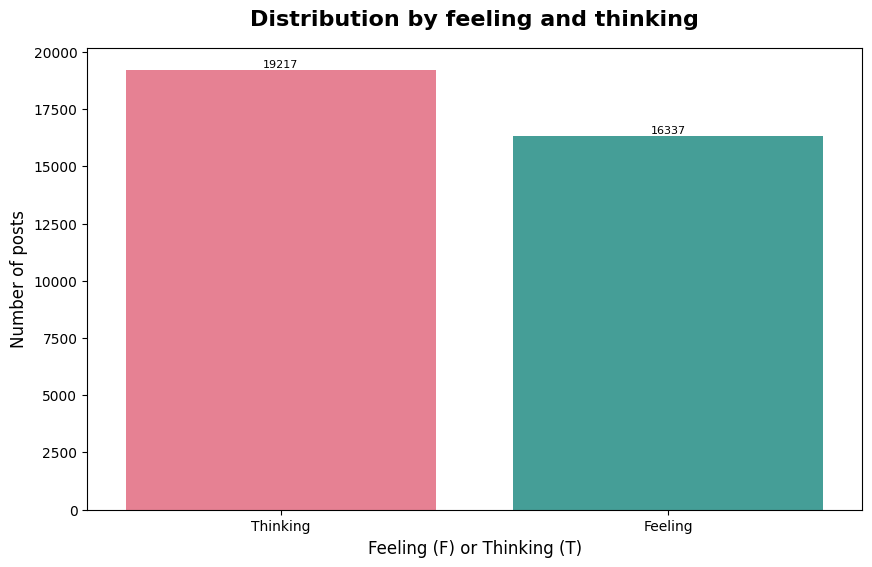

In [11]:
mbti_df_grouped = mbti_df.groupby('feeling_thinking').size().reset_index(name='n_posts')
mbti_df_grouped = mbti_df_grouped.sort_values(by='n_posts', ascending=False)
mbti_df_grouped.columns = ['feeling_thinking', 'n_posts']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mbti_df_grouped, x='feeling_thinking', y='n_posts', palette='husl')

# Add annotations (number of users above each bar)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

plt.title('Distribution by feeling and thinking', fontsize=16, fontweight='bold', pad=16)
plt.xlabel('Feeling (F) or Thinking (T)', fontsize=12)
plt.ylabel('Number of posts', fontsize=12)

plt.show()

In [12]:
mbti_labels_dict = {
    'Feeling': 0,
    'Thinking': 1,
}

### Split datasets

In [13]:
X = mbti_df['tweet']
y = mbti_df['feeling_thinking']

y = y.map(mbti_labels_dict)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


### Fine Tune BERT

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  
model.config.hidden_dropout_prob = 0.3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
inputs = tokenizer(X.tolist(), padding=True, truncation=True, max_length=32, return_tensors='pt')
labels = torch.tensor(y.values) 

train_dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.3)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [18]:
import joblib

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

losses = []
acc = []
prec = []
recalls = []
f1score = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track predictions and labels
        preds = logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(train_dataloader)

    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
    
    # Calculate metrics (accuracy, precision, recall, F1-score)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    acc.append(accuracy)
    prec.append(precision)
    recalls.append(recall)
    f1score.append(f1)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


joblib.dump(model, 'data/model_5.joblib')
joblib.dump(tokenizer, 'data/tokenizer_5.joblib')

Epoch 1/10, Loss: 0.6755402294444854
Accuracy: 0.5816, Precision: 0.5775, Recall: 0.5816, F1-Score: 0.5660
Epoch 2/10, Loss: 0.632331579712945
Accuracy: 0.6468, Precision: 0.6454, Recall: 0.6468, F1-Score: 0.6428
Epoch 3/10, Loss: 0.5314533023647293
Accuracy: 0.7369, Precision: 0.7365, Recall: 0.7369, F1-Score: 0.7357
Epoch 4/10, Loss: 0.35058789481923636
Accuracy: 0.8516, Precision: 0.8515, Recall: 0.8516, F1-Score: 0.8514
Epoch 5/10, Loss: 0.19543328992232373
Accuracy: 0.9243, Precision: 0.9243, Recall: 0.9243, F1-Score: 0.9243
Epoch 6/10, Loss: 0.1137969840547204
Accuracy: 0.9571, Precision: 0.9571, Recall: 0.9571, F1-Score: 0.9571
Epoch 7/10, Loss: 0.0805784103466296
Accuracy: 0.9707, Precision: 0.9707, Recall: 0.9707, F1-Score: 0.9707
Epoch 8/10, Loss: 0.0646265822422037
Accuracy: 0.9770, Precision: 0.9770, Recall: 0.9770, F1-Score: 0.9770
Epoch 9/10, Loss: 0.048317252781044914
Accuracy: 0.9820, Precision: 0.9820, Recall: 0.9820, F1-Score: 0.9820
Epoch 10/10, Loss: 0.0429669941090

['data/tokenizer_5.joblib']

In [31]:
import joblib

joblib.dump(model, 'data/model_3.joblib')
joblib.dump(tokenizer, 'data/tokenizer_3.joblib')

['data/tokenizer_3.joblib']

### Loss

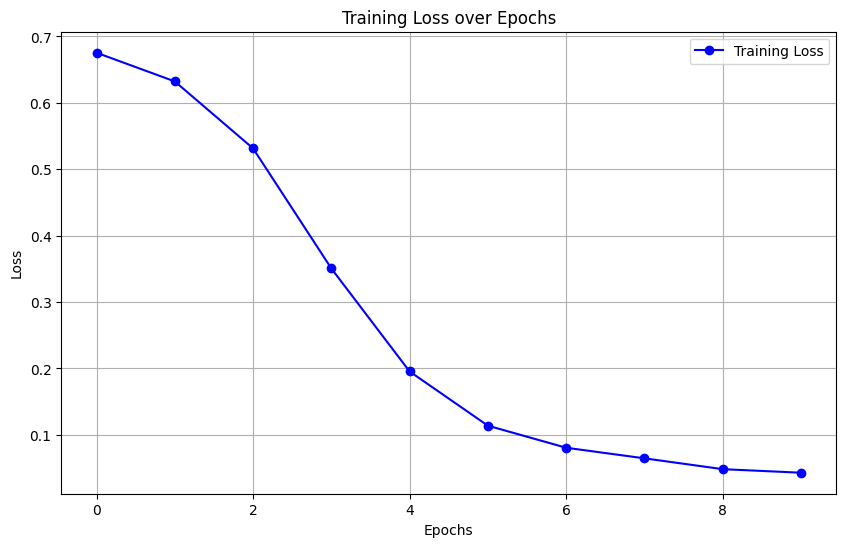

In [19]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss', color='b', marker='o')  # Plot losses
plt.title('Training Loss over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show gridlines for better readability
plt.show()  # Display the plot

### Accuracy, precision, recall, and f1-score

In [20]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(all_preds, all_labels))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11391
           1       0.99      0.99      0.99     13496

    accuracy                           0.98     24887
   macro avg       0.98      0.98      0.98     24887
weighted avg       0.98      0.98      0.98     24887



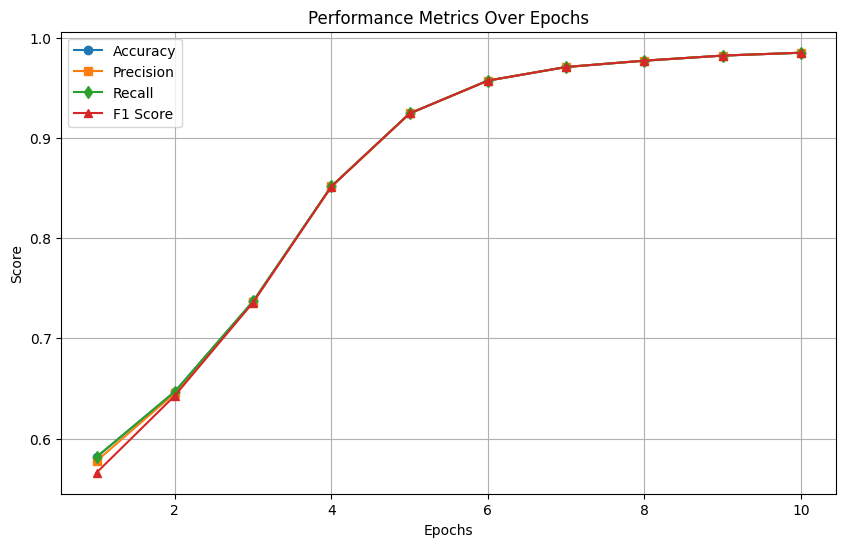

In [21]:
epochs = range(1, len(acc) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Accuracy', marker='o')
plt.plot(epochs, prec, label='Precision', marker='s')
plt.plot(epochs, recalls, label='Recall', marker='d')
plt.plot(epochs, f1score, label='F1 Score', marker='^')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Performance Metrics Over Epochs')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Evaluation

In [2]:
import joblib 

model = joblib.load('data/model_2.joblib')
tokenizer = joblib.load('data/tokenizer_2.joblib')

c:\Users\fizuf\anaconda3\envs\vidovax-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import torch

model.eval()  # Set model to evaluation mode

val_preds = []
val_labels = []
all_attentions = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        all_attentions.append(attentions)
        logits = outputs.logits
        preds = logits.argmax(dim=-1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())
                        
    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='weighted')

    print(f"Testing - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}")

# Print classification report using val_preds and val_labels
print(classification_report(val_labels, val_preds))


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Testing - Accuracy: 0.5772, Precision: 0.5745, Recall: 0.5772, F1-Score: 0.5731
              precision    recall  f1-score   support

           0       0.55      0.47      0.51      4962
           1       0.59      0.67      0.63      5705

    accuracy                           0.58     10667
   macro avg       0.57      0.57      0.57     10667
weighted avg       0.57      0.58      0.57     10667



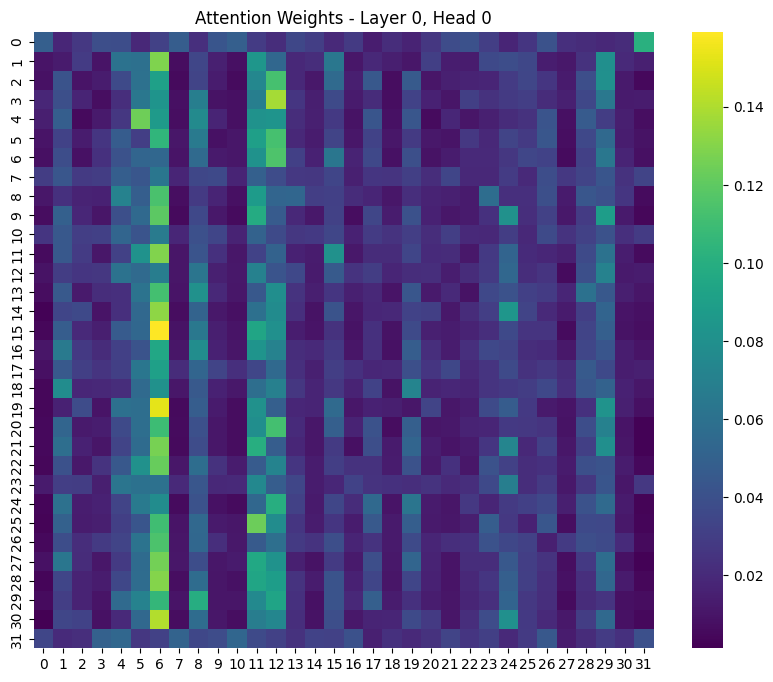

In [23]:
layer = 0  # First layer
head = 0   # First attention head
attention_weights = attentions[layer][0, head].cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, annot=False, cmap='viridis')
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.show()